In [2]:
%load_ext autoreload
%autoreload 2
from awesome.run.awesome_config import AwesomeConfig
from awesome.run.awesome_runner import AwesomeRunner
from awesome.util.reflection import class_name
import os
import torch
import numpy as np
from awesome.model.convex_diffeomorphism_net import ConvexDiffeomorphismNet
from awesome.util.path_tools import get_project_root_path
from awesome.util.logging import basic_config
from awesome.dataset.awesome_dataset import AwesomeDataset
from awesome.dataset.fbms_sequence_dataset import FBMSSequenceDataset
from awesome.measures.fbms_joint_loss import FBMSJointLoss
from awesome.model.unet import UNet
from awesome.measures.weighted_loss import WeightedLoss
from awesome.measures.se import SE
from awesome.measures.unaries_conversion_loss import UnariesConversionLoss
from typing import Literal
from awesome.run.functions import get_result, split_model_result, plot_image_scribbles
import matplotlib.pyplot as plt
from awesome.run.functions import get_mpl_figure, plot_mask, prepare_input_eval
from awesome.util.matplotlib import saveable
from typing import Optional, Tuple
from awesome.model.path_connected_net import PathConnectedNet, minmax
from matplotlib.axes import Axes

basic_config()
os.chdir(get_project_root_path()) # Beeing in the root directory of the project is important for the relative paths to work consistently

In [28]:
from awesome.analytics.result_model import ResultModel


path = "runs/fbms_local/eval/unet/joint_realnvp/2024-01-11/#05_UNET+cars3+edge+diffeo+original+joint_24_01_11_17_06_14"
index = 10

# path = "./runs/fbms_local/eval/unet/joint_realnvp/2024-01-11/#16_UNET+horses01+edge+diffeo+original+joint_24_01_11_17_06_14"
# index = 162


#path = "./runs/fbms_local/eval/unet/joint_realnvp/2024-01-11/#11_UNET+cats05+edge+diffeo+original+joint_24_01_11_17_06_14"
#index = 35

result_model = ResultModel.from_path(path)
runner = result_model.get_runner(0)

model = runner.agent._get_model()
dataloader = runner.agent.training_dataset
model_gets_targets = runner.agent.model_gets_targets

res, ground_truth, img, fg, bg = get_result(model, dataloader, 0, model_gets_targets=model_gets_targets)
res = split_model_result(res, model, dataloader, img)
res_prior = res.get("prior", None)
res_pred = res["segmentation"]
boxes = res.get("boxes", None)
labels = res.get("labels", None)

2024-01-24:17:01:33.334 INFO     [tensorboard.py:55] Tensorboard logger created at: runs\fbms_local\eval\unet\joint_realnvp\2024-01-11\#05_UNET+cars3+edge+diffeo+original+joint_24_01_11_17_06_14
2024-01-24:17:01:35.299 WARNING  [awesome_runner.py:150] Patch Agent is currently not fully implemented!


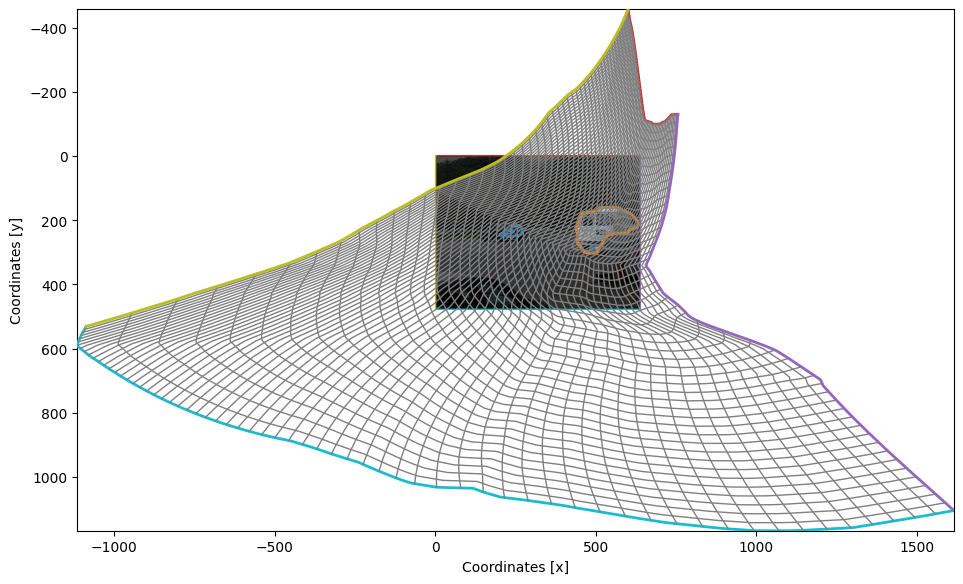

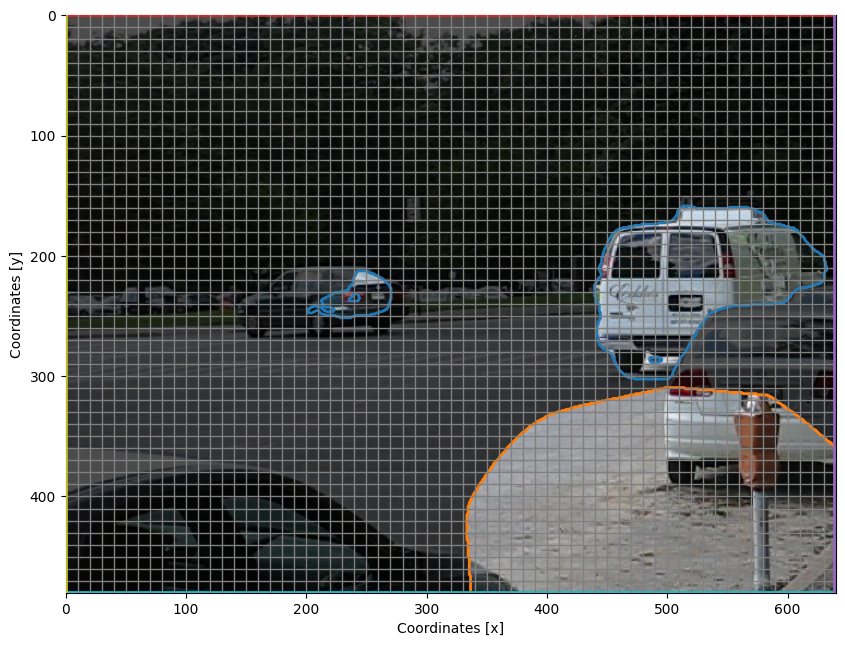

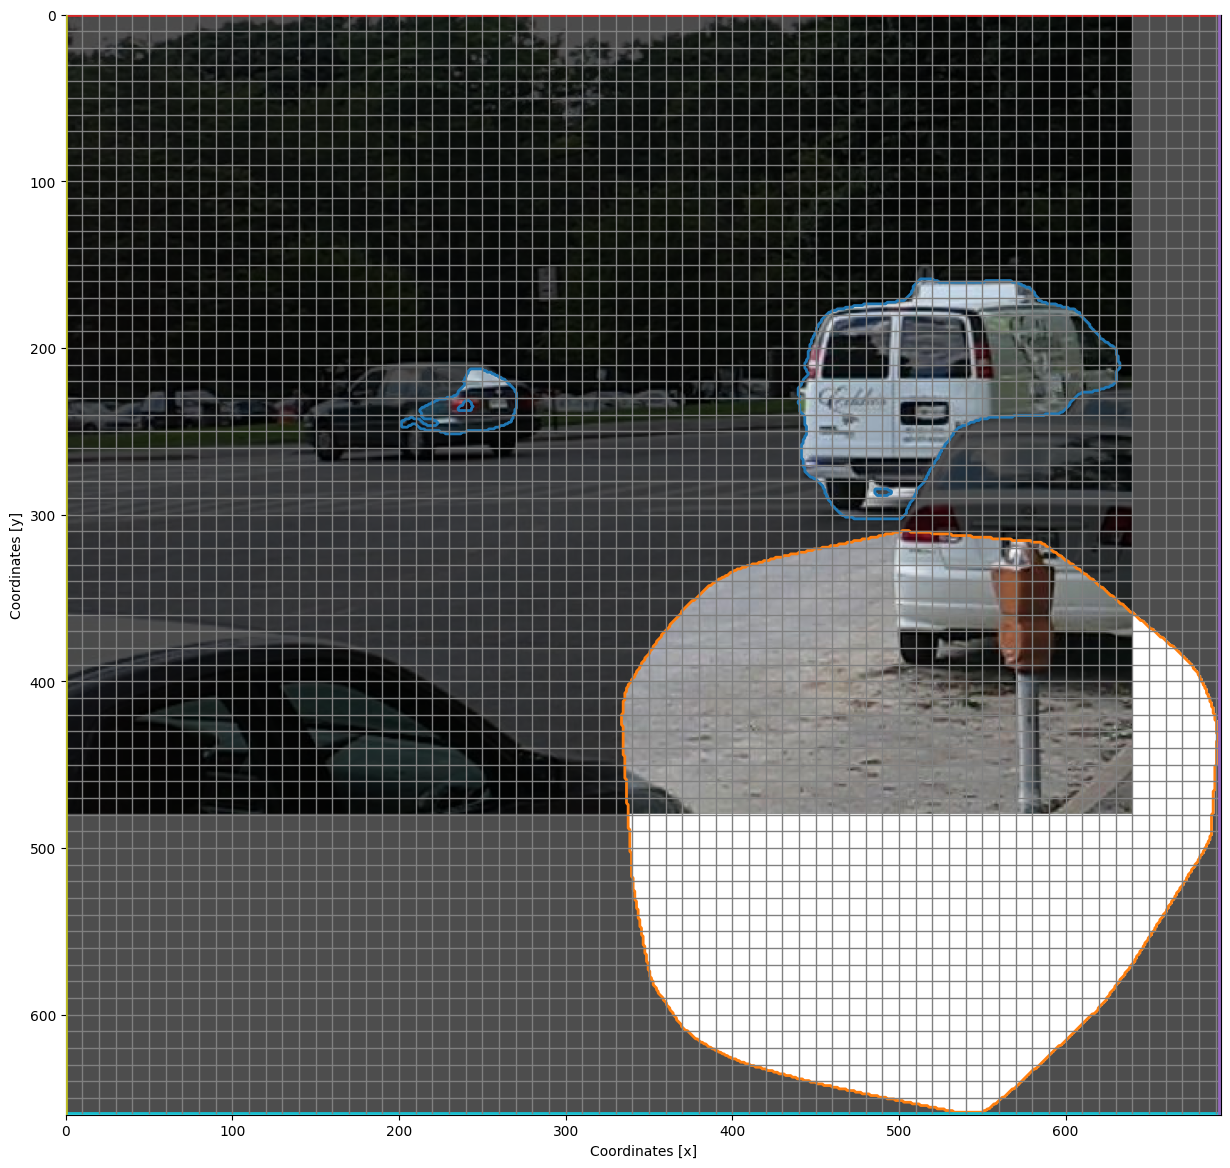

In [29]:
from awesome.model.path_connected_net import PathConnectedNet
import numpy as np
from awesome.run.functions import plot_as_image, subsample_mask, plot_grid, plot_match, plot_output_grid


#indices = range(len(dataloader))
from awesome.util.temporary_property import TemporaryProperty


indices = [index] #len(dataloader)

output_path = "output/deformed_grid_plots/"
os.makedirs(output_path, exist_ok=True)

for i in indices:
    res, ground_truth, img, fg, bg = get_result(model, dataloader, i, model_gets_targets=model_gets_targets)
    res = split_model_result(res, model, dataloader, img)
    res_prior = res.get("prior", None)
    res_pred = res["segmentation"]
    boxes = res.get("boxes", None)
    labels = res.get("labels", None)

    
    with torch.no_grad(), TemporaryProperty(dataloader, do_image_blurring=False, image_channel_format="rgb"):
        model.eval()
        model.to(torch.device("cpu"))
        image_no_blur, ground_truth, _input, targets, fg, bg, prior_state = prepare_input_eval(dataloader, model, i)
        _input_grid = _input[2][None, ...]
        grid = model.prior_module.get_deformation(_input_grid)[0]
        no_deformation = model.prior_module.convex_net(_input_grid)[0]

        step_sizes = (1 / torch.tensor(grid.shape[:-3:-1], dtype=torch.float64))

        result_prior = (1 - res_prior).bool()[0]

        # Min y x by diffeo
        min_xy_net = torch.tensor(grid[:, result_prior].numpy().min(axis=(-1)))

        min_start = torch.stack([min_xy_net, torch.tensor([0, 0])]).min(dim=0).values


        max_xy_net = torch.tensor(grid[:, result_prior].numpy().max(axis=(-1)))
        max_end = torch.stack([max_xy_net, torch.tensor([1, 1])]).max(dim=0).values
        # Round steps so we have 0,0 inside the grid and same sample points as with the original grid
        
        min_start = -torch.ceil(torch.abs(min_start) / step_sizes) * step_sizes
        max_end = torch.ceil(max_end / step_sizes) * step_sizes

        origin_idx = torch.round(-min_start / step_sizes).int()
        max_original_extend_idx = (origin_idx + torch.tensor(grid.shape[:-3:-1]))

        x = torch.arange(min_start[0], max_end[0] + step_sizes[0], step_sizes[0])
        y = torch.arange(min_start[1], max_end[1] + step_sizes[1], step_sizes[1])
        yy, xx = torch.meshgrid(y, x)

        max_flat_grid = torch.stack([xx, yy], dim=0)[None, ...]
        no_deformation_large_grid = model.prior_module.convex_net(max_flat_grid)[0]
        with_deformation_large_grid = model.prior_module(max_flat_grid)[0]


    fig = plot_output_grid(image_no_blur, 1 - res_prior, 1 - res_pred, grid=grid, 
                      size=10, 
                      subsample=10,
                      grid_color="gray",
                      grid_linewidth=1,
                      grid_outer_linewidth=2,
                      grid_scale_mode="original",
                      tight=False,
                      save=True,
                      ext=["png", "pdf"],
                      transparent=True,
                      override=True,
                      tight_layout=True,
                      path=os.path.join(output_path, f"grid_img_{i}_{dataloader.__dataset__.dataset_name}")
                    )
    
    display(fig)
    plt.close(fig)
    
    fig = plot_output_grid(image_no_blur, (1 - torch.sigmoid(no_deformation)) > 0.5, 1 - res_pred, grid=_input_grid[0], 
                      size=10, 
                      subsample=10,
                      grid_color="gray",
                      grid_linewidth=1,
                      grid_outer_linewidth=2,
                      grid_scale_mode="like_image",
                      show_nav_frame=False,
                      tight=False,
                      save=True,
                      ext=["png", "pdf"],
                      transparent=True,
                      override=True,
                      path=os.path.join(output_path, f"grid_no_deform_img_{i}_{dataloader.__dataset__.dataset_name}")
                    )
    display(fig)
    plt.close(fig)


    enlarged_image = torch.zeros((4, *no_deformation_large_grid.shape[-2:]))
    enlarged_pred = torch.zeros((1, *no_deformation_large_grid.shape[-2:]))
    
    enlarged_image[:, origin_idx[1]:max_original_extend_idx[1], origin_idx[0]:max_original_extend_idx[0]] = torch.cat([image_no_blur, torch.ones_like(image_no_blur[0])[None,]], dim=0)
    enlarged_pred[:, origin_idx[1]:max_original_extend_idx[1], origin_idx[0]:max_original_extend_idx[0]] = 1 - res_pred
    prior_enlarged_mask = (1 - torch.sigmoid(no_deformation_large_grid)) > 0.5
    fig = plot_output_grid(enlarged_image, prior_enlarged_mask, enlarged_pred, grid=max_flat_grid[0], 
                      size=15, 
                      subsample=10,
                      grid_color="gray",
                      grid_linewidth=1,
                      grid_outer_linewidth=2,
                      grid_scale_mode="like_image",
                      show_nav_frame=False,
                      tight=False,
                      save=True,
                      ext=["png", "pdf"],
                      transparent=True,
                      override=True,
                      path=os.path.join(output_path, f"grid_no_deform_enlarged_img_{i}_{dataloader.__dataset__.dataset_name}")
                    )
    display(fig)
    plt.close(fig)

    # fig = plot_output_grid(enlarged_image, (1 - torch.sigmoid(with_deformation_large_grid)) > 0.5, enlarged_pred, grid=max_flat_grid[0], 
    #                   size=15, 
    #                   subsample=10,
    #                   grid_linewidth=2,
    #                   grid_outer_linewidth=1,
    #                   grid_scale_mode="like_image",
    #                   show_nav_frame=False,
    #                   tight=True,
    #                 )

    # display(fig)
    # plt.close(fig)



In [30]:
import math
import cv2 as cv

from awesome.run.functions import get_cleaned_up_sam_masks

prior_no_deform_mask = (1 - (torch.sigmoid(no_deformation)) > 0.5)[0]
result_prior = (1 - res_prior).bool()[0]

masks_sam = get_cleaned_up_sam_masks(image_no_blur, result_prior)

def grid_to_original_dim(grid, image_shape):
    return minmax(grid, torch.tensor(0), torch.tensor(1), 0, (torch.tensor(image_shape[::-1]) - 1)[:, None, None])

def grid_to_img_dim(grid, image_shape):
    return minmax(grid, torch.tensor(grid.numpy().min(axis=(-1, -2)))[:, None, None],
                            torch.tensor(grid.numpy().max(axis=(-1, -2)))[:, None, None], 0, 
                            (torch.tensor(image_shape[::-1]) - 1)[:, None, None])

norm_grid = grid_to_original_dim(_input_grid[0], grid.shape[-2:])
norm_enlarged_grid = grid_to_original_dim(max_flat_grid[0], grid.shape[-2:])
target_grid = grid_to_original_dim(grid, grid.shape[-2:])

def simplistic_flow_net_inverse(norm_grid: torch.Tensor, target_grid: torch.Tensor, shape: torch.Tensor):
    transf = target_grid[:, shape]
    min_xy = norm_grid.min(dim=-1).values.min(dim=-1).values
    max_xy = norm_grid.max(dim=-1).values.max(dim=-1).values
    transf = torch.clamp(transf.T, min_xy, max_xy).T
    transf = transf.int()
    msk = torch.zeros_like(norm_grid[0], dtype=torch.bool)
    msk[transf[1], transf[0]] = True
    return msk

ded_tensor = masks_sam

masks_in_original_convex = torch.zeros_like(ded_tensor, dtype=torch.bool)
masks_in_original_convex_enlarged = torch.zeros((ded_tensor.shape[0], *no_deformation_large_grid.shape[-2:]), dtype=torch.bool)

masks_in_prior = torch.zeros_like(ded_tensor, dtype=torch.bool)

for i in range(ded_tensor.shape[0]):
    in_msk = ded_tensor[i].bool() & result_prior
    masks_in_prior[i] = in_msk
    masks_in_original_convex[i] = simplistic_flow_net_inverse(norm_grid, target_grid, in_msk)
    masks_in_original_convex_enlarged[i] = simplistic_flow_net_inverse(norm_enlarged_grid, target_grid, in_msk)


2024-01-24:17:03:12.316 WARNING  [functions.py:1254] Overlap in classes detected, class 2 overlaps with class(es) 1
2024-01-24:17:03:12.318 WARNING  [functions.py:1254] Overlap in classes detected, class 3 overlaps with class(es) 2
2024-01-24:17:03:12.320 WARNING  [functions.py:1254] Overlap in classes detected, class 4 overlaps with class(es) 2
2024-01-24:17:03:12.322 WARNING  [functions.py:1254] Overlap in classes detected, class 5 overlaps with class(es) 2
2024-01-24:17:03:12.324 WARNING  [functions.py:1254] Overlap in classes detected, class 6 overlaps with class(es) 5
2024-01-24:17:03:12.326 WARNING  [functions.py:1254] Overlap in classes detected, class 7 overlaps with class(es) 4
2024-01-24:17:03:12.328 WARNING  [functions.py:1254] Overlap in classes detected, class 8 overlaps with class(es) 3
2024-01-24:17:03:12.329 WARNING  [functions.py:1254] Overlap in classes detected, class 9 overlaps with class(es) 1, 2
2024-01-24:17:03:12.331 WARNING  [functions.py:1254] Overlap in class

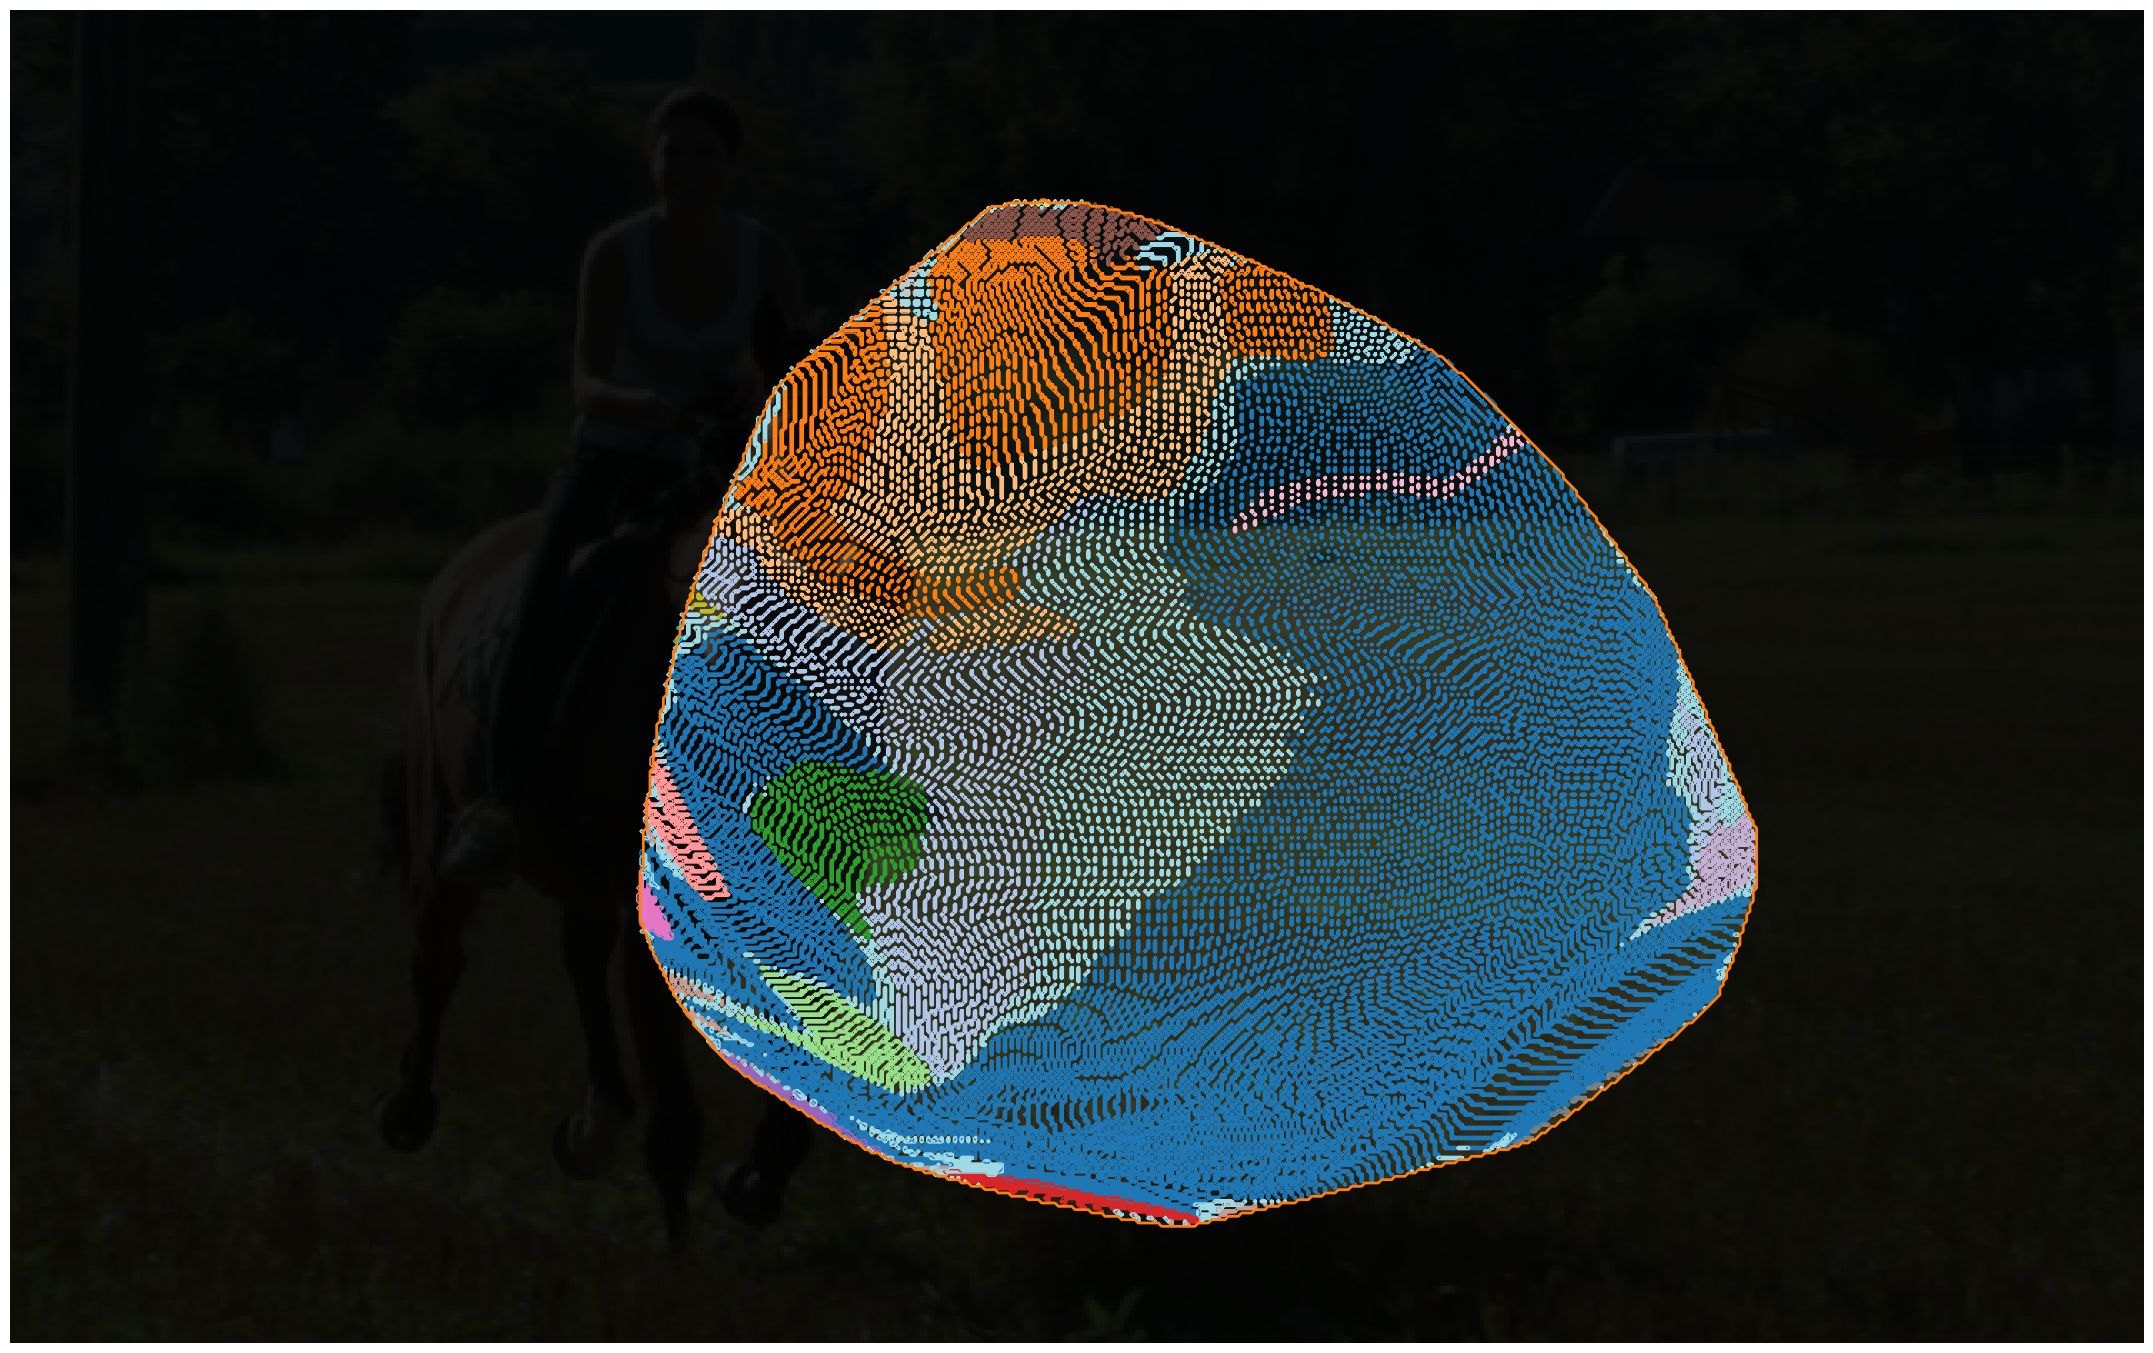

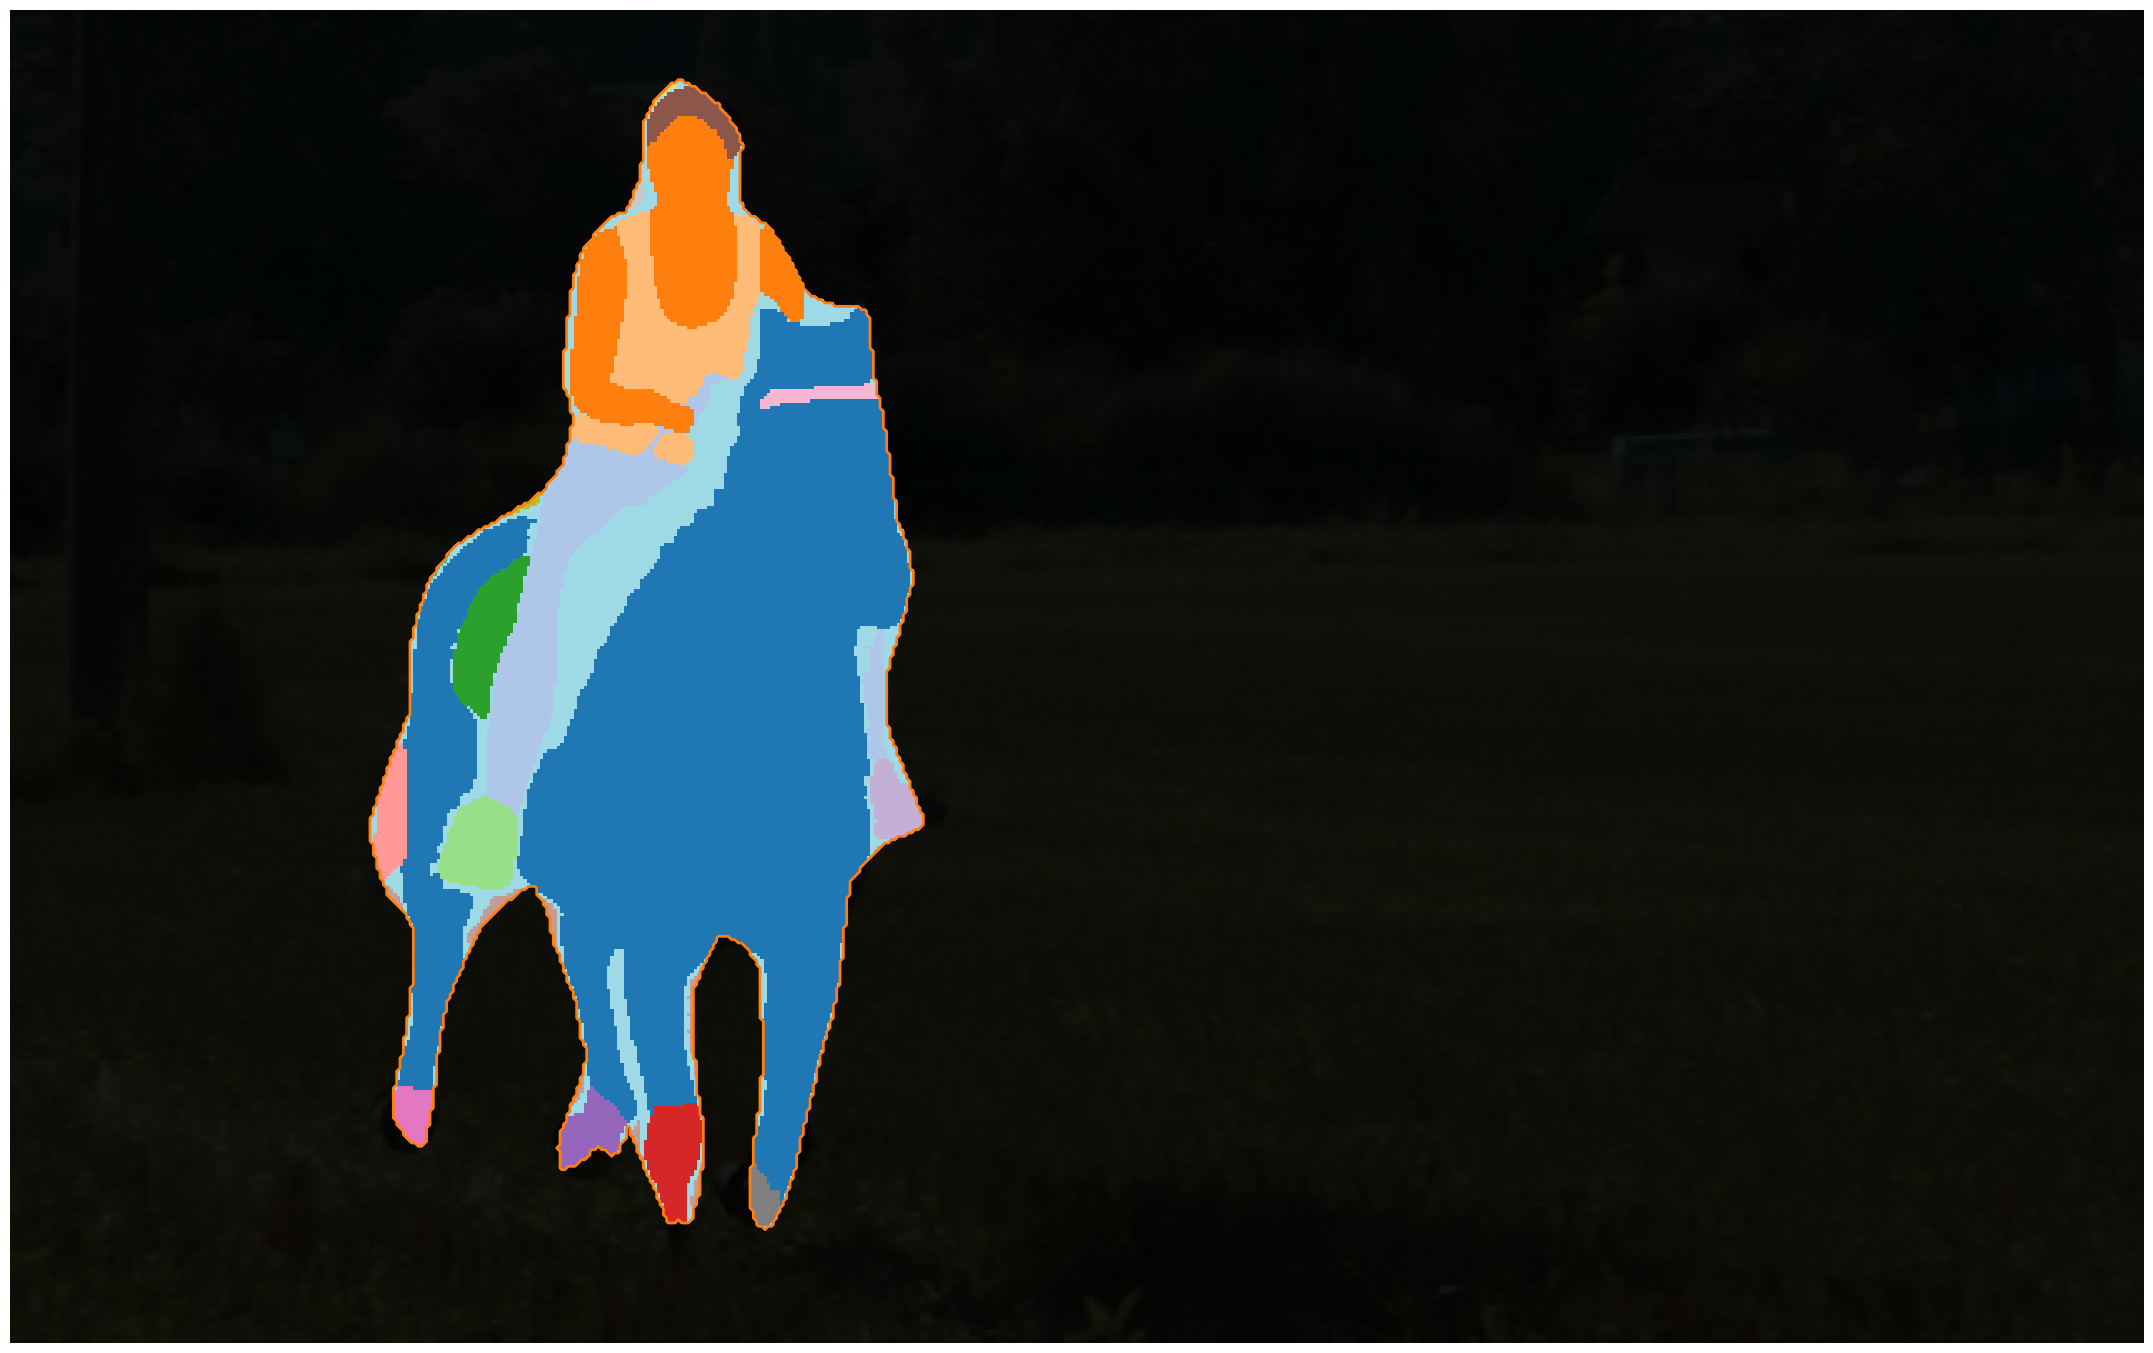

In [27]:

fig = plot_mask(image_no_blur, masks_in_original_convex_enlarged,
                filled_contours=True,
                contour_linewidths=1, 
                #darkening_background=0,
                axes_description=True,
                lined_contours=True, 
                tight=False,
                size=10)

plot_mask(None, prior_enlarged_mask,ax=fig.axes[0],
          override=True,
          save=True,
          color=plt.get_cmap("tab10")(1),
          axes_description=True,
          ext=["png", "pdf"],
          transparent=True,
          path=os.path.join(output_path, f"grid_sam_seg_img_enlarged_{index}_{dataloader.__dataset__.dataset_name}"),
          )
display(fig)
plt.close(fig)


fig = plot_mask(image_no_blur, masks_in_original_convex,  filled_contours=True, contour_linewidths=1, 
                #darkening_background=0,
                tight=False,
                size=10)
plot_mask(None, prior_no_deform_mask, ax=fig.axes[0],
                override=True,
                save=True,
                color=plt.get_cmap("tab10")(1),
                axes_description=True,
                ext=["png", "pdf"],
                transparent=True,
                path=os.path.join(output_path, f"grid_no_deform_sam_seg_img_{index}_{dataloader.__dataset__.dataset_name}"),
          
          )


display(fig)
plt.close(fig)

fig = plot_mask(image_no_blur, masks_in_prior,
                filled_contours=True, 
                lined_contours=False, 
                #darkening_background=0,
                tight=False,
                size=10)

plot_mask(None, result_prior,ax=fig.axes[0],
            override=True,
            save=True,
            axes_description=True,
            color=plt.get_cmap("tab10")(1),
            ext=["png", "pdf"],
            transparent=True,
            path=os.path.join(output_path, f"grid_sam_seg_img_{index}_{dataloader.__dataset__.dataset_name}"),
          )

display(fig)
plt.close(fig)


fig = plot_mask(image_no_blur, masks_in_original_convex,  filled_contours=True, contour_linewidths=1, 
                #darkening_background=0,
                tight=True,
                size=10)
plot_mask(None, prior_no_deform_mask, ax=fig.axes[0],
                override=True,
                save=True,
                color=plt.get_cmap("tab10")(1),
                axes_description=False,
                ext=["png", "pdf"],
                transparent=True,
                path=os.path.join(output_path, f"grid_no_deform_tight_sam_seg_img_{index}_{dataloader.__dataset__.dataset_name}"),
          )


display(fig)
plt.close(fig)

fig = plot_mask(image_no_blur, masks_in_prior,
                filled_contours=True, 
                lined_contours=False, 
                #darkening_background=0,
                tight=True,
                size=10)

plot_mask(None, result_prior,ax=fig.axes[0],
            override=True,
            save=True,
            axes_description=False,
            color=plt.get_cmap("tab10")(1),
            ext=["png", "pdf"],
            transparent=True,
            path=os.path.join(output_path, f"grid_tight_sam_seg_img_{index}_{dataloader.__dataset__.dataset_name}"),
          )
          
display(fig)
plt.close(fig)

In [46]:
norm_grid

tensor([[[  0.,   1.,   2.,  ..., 637., 638., 639.],
         [  0.,   1.,   2.,  ..., 637., 638., 639.],
         [  0.,   1.,   2.,  ..., 637., 638., 639.],
         ...,
         [  0.,   1.,   2.,  ..., 637., 638., 639.],
         [  0.,   1.,   2.,  ..., 637., 638., 639.],
         [  0.,   1.,   2.,  ..., 637., 638., 639.]],

        [[  0.,   0.,   0.,  ...,   0.,   0.,   0.],
         [  1.,   1.,   1.,  ...,   1.,   1.,   1.],
         [  2.,   2.,   2.,  ...,   2.,   2.,   2.],
         ...,
         [477., 477., 477.,  ..., 477., 477., 477.],
         [478., 478., 478.,  ..., 478., 478., 478.],
         [479., 479., 479.,  ..., 479., 479., 479.]]])

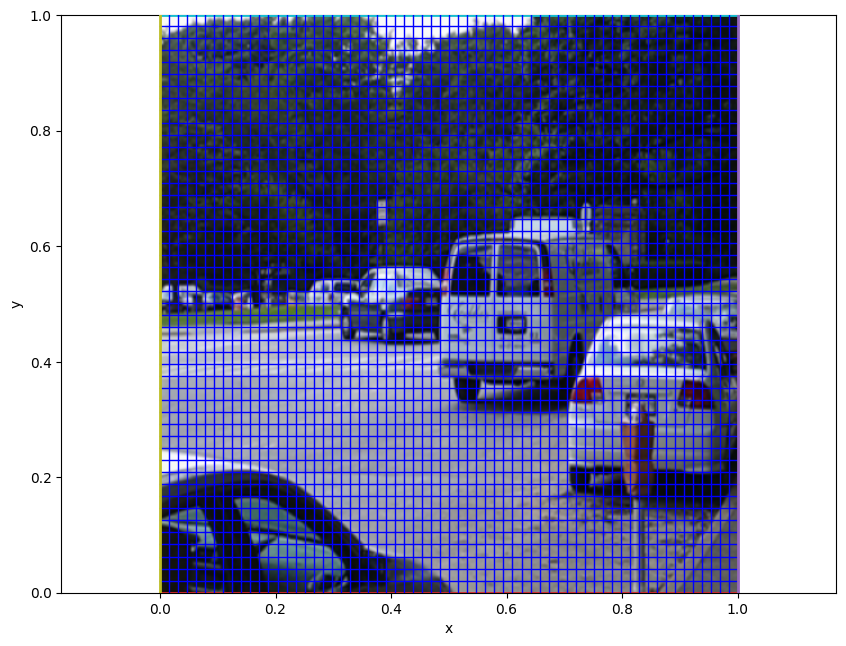

In [127]:
from matplotlib.colors import to_rgba, get_named_colors_mapping
g = _input_grid[0]
#g = grid

frame_colors = ["tab:red", "tab:purple", "tab:cyan", "tab:olive"]
cmap = get_named_colors_mapping()
for idx, color in enumerate(frame_colors):
    if isinstance(color, str):
        frame_colors[idx] = to_rgba(cmap[color])

msk = subsample_mask(g, subsample=10, also_last=True)
fig = plot_grid(g, msk, size=10, origin=None, outer_line_colors=frame_colors, grid_outer_linewidth=2)

ax = fig.axes[0]
ax.axis("equal")
ax.imshow(img.permute(1,2,0).numpy(), extent=[0, 1, 0, 1])
ax.set_xlabel("x")
ax.set_ylabel("y")
fig

In [106]:
x.shape

torch.Size([113])

In [78]:
grid.shape

torch.Size([2, 480, 640])

In [74]:
_input_grid[0]

tensor([[[0.0000, 0.0016, 0.0031,  ..., 0.9969, 0.9984, 1.0000],
         [0.0000, 0.0016, 0.0031,  ..., 0.9969, 0.9984, 1.0000],
         [0.0000, 0.0016, 0.0031,  ..., 0.9969, 0.9984, 1.0000],
         ...,
         [0.0000, 0.0016, 0.0031,  ..., 0.9969, 0.9984, 1.0000],
         [0.0000, 0.0016, 0.0031,  ..., 0.9969, 0.9984, 1.0000],
         [0.0000, 0.0016, 0.0031,  ..., 0.9969, 0.9984, 1.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0021, 0.0021, 0.0021,  ..., 0.0021, 0.0021, 0.0021],
         [0.0042, 0.0042, 0.0042,  ..., 0.0042, 0.0042, 0.0042],
         ...,
         [0.9958, 0.9958, 0.9958,  ..., 0.9958, 0.9958, 0.9958],
         [0.9979, 0.9979, 0.9979,  ..., 0.9979, 0.9979, 0.9979],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]]])

In [13]:
from awesome.analytics.result_model import ResultModel


path = "runs/fbms_local/eval/unet/joint_realnvp/2024-01-11/#05_UNET+cars3+edge+diffeo+original+joint_24_01_11_17_06_14"
result_model = ResultModel.from_path(path)
runner = result_model.get_runner(0)

model = runner.agent._get_model()
dataloader = runner.agent.training_dataset
model_gets_targets = runner.agent.model_gets_targets

res, ground_truth, img, fg, bg = get_result(model, dataloader, 0, model_gets_targets=model_gets_targets)
res = split_model_result(res, model, dataloader, img)
res_prior = res.get("prior", None)
res_pred = res["segmentation"]
boxes = res.get("boxes", None)
labels = res.get("labels", None)

2024-01-19:13:46:20.334 INFO     [tensorboard.py:55] Tensorboard logger created at: runs\fbms_local\eval\unet\joint_realnvp\2024-01-11\#05_UNET+cars3+edge+diffeo+original+joint_24_01_11_17_06_14
2024-01-19:13:46:21.068 WARNING  [awesome_runner.py:150] Patch Agent is currently not fully implemented!


In [30]:
from awesome.run.functions import get_mpl_figure, plot_mask, prepare_input_eval
from awesome.util.matplotlib import saveable
import normflows as nf
from typing import Optional, Tuple
from awesome.model.path_connected_net import PathConnectedNet, minmax
from matplotlib.axes import Axes

def coordinate_grid(image_shape):
    x = torch.arange(image_shape[1]).float()
    y = torch.arange(image_shape[0]).float()
    yy, xx = torch.meshgrid(y, x)
    return torch.stack([yy, xx])

def create_circle(image_shape: Tuple[int, int], radius: float, center: Tuple[float, float]):
    grid = coordinate_grid(image_shape)
    yy, xx = grid
    circle = (yy - center[0])**2 + (xx - center[1])**2 <= radius**2
    return circle.float()[None, ...]

def subsample_mask(x,
                   subsample: int = 25):
    image_shape = x.shape[-2:]

    ones_grid = torch.ones(x[0].shape)
    subsampled_grid = torch.zeros(x[0].shape)
    coords = (torch.argwhere(ones_grid) % subsample) == 0
    coords_mask = coords.all(dim=-1).reshape((image_shape))
    subsampled_grid[coords_mask] = 1
    return subsampled_grid.bool()

@saveable()
def plot_output(img, 
                output, 
                target, 
                grid: torch.Tensor, 
                subsample:int = 25, 
                **kwargs):
    image_shape = grid.shape[-2:]
    def denorm_grid(grid):
        image_shape = grid.shape[-2:]
        grid_y = minmax(grid[0], grid[0].min(), grid[0].max(), 0, image_shape[0])
        grid_x = minmax(grid[1], grid[1].min(), grid[1].max(), 0, image_shape[1])
        grid_dnorm = torch.cat([grid_y[None, ...], grid_x[None, ...]], dim=0).detach().cpu().numpy()
        return grid_dnorm

    fig = plot_match(img, output, target, size=5, tight=True, subsample=subsample)
    ax = fig.axes[0]
    dnorm_grid_pt = denorm_grid(grid)

    dnorm_grid_pt = torch.clamp(torch.tensor(dnorm_grid_pt), min=torch.tensor([[[0]], [[0]]]), max=torch.tensor([[[image_shape[0] - 1]], [[image_shape[1] - 1]]])).numpy()
    
    msk = subsample_mask(dnorm_grid_pt, subsample=subsample)

    return plot_grid(dnorm_grid_pt, msk, ax, 'g', origin="lower")
    
@saveable()
def plot_grid(grid: torch.Tensor, 
              mask: torch.Tensor, 
              ax: Optional[Axes] = None, 
              tight: Optional[bool] = False,
              size: Optional[float] = 5,
              color: str = "b",
              dense: bool = True,
              origin: Literal['lower', 'upper'] = "upper"
              ):
    if ax is None:
        fig, ax = get_mpl_figure(1, 1, tight=tight, size=size, ratio_or_img=grid)
    else:
        fig = ax.figure

    dots = torch.argwhere(mask)

    col_idx = torch.unique(dots[:, 0])
    row_idx = torch.unique(dots[:, 1])

    cols = grid[:, col_idx]
    rows = grid[:, :, row_idx]

    for idx in range(cols.shape[1]):
        col = cols[:, idx]
        if dense:
            x = col[1]
            y = col[0]
        else:
            x = col[1, row_idx]
            y = col[0, row_idx]
        ax.plot(x, y, color=color)

    for idx in range(rows.shape[2]):
        row = rows[:, :, idx]
        if dense:
            x = row[1]
            y = row[0]
        else:
            x = row[1, col_idx]
            y = row[0, col_idx]
        ax.plot(x, y, color=color)

    if origin == "upper":
        ax.invert_yaxis()
    return fig


def plot_match(img, 
               output, 
               target, 
               subsample:int = 25, 
               grid: torch.Tensor = None,
               **kwargs):

    image_shape = img.shape[-2:]
    if grid is None:
        grid = coordinate_grid(image_shape)

    subsampled_grid = torch.zeros_like(grid[0])

    coords_mask = subsample_mask(grid, subsample=subsample)
    subsampled_grid[coords_mask] = 1

    add = []

    if target is not None:
        add.append(target)
    if output is not None:
        add.append(output)
    
    add.append(subsampled_grid.float()[None, ...])

    stack_plot = torch.cat(add, dim=0)

    fig = plot_mask(img, stack_plot, **kwargs)
    return fig


